<a href="https://colab.research.google.com/github/abeerfatimaa/Binance-Price-Prediction-Using-Neural-Networks/blob/main/Binance_Price_Prediction_Using_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# importing libraries
import tensorflow as tf
import pandas as pd
import numpy as np
#loading data file
df = pd.read_csv('Data File.csv')
#shows first five rows of the data
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,5/21/2024,0.000192,0.000187,0.000202,0.000185,10.86B,3.22%
1,5/20/2024,0.000186,0.000179,0.000187,0.000175,8.07B,3.79%
2,5/19/2024,0.000179,0.000200,0.000200,0.000175,20.31B,-11.49%
3,5/18/2024,0.000203,0.000181,0.000225,0.000176,32.66B,12.49%
4,5/17/2024,0.000180,0.000171,0.000186,0.000169,5.21B,5.69%


In [3]:
# Displaying basic statistics of the dataset
df.describe()

,Price,Open,High,Low
count,726.000000,726.000000,726.000000,726.000000
mean,0.000339,0.000341,0.000359,0.000326
std,0.000185,0.000191,0.000208,0.000175
min,0.000165,0.000165,0.000170,0.000159
25%,0.000211,0.000210,0.000216,0.000205
50%,0.000296,0.000296,0.000305,0.000287
75%,0.000406,0.000407,0.000427,0.000386
max,0.001618,0.001629,0.001793,0.001559


In [4]:
# Checking for missing values
df.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [14]:
# Converting 'Volume' from strings with 'B' (billions) and 'M' (millions) to float
def convert_volume(volume_str):
    if isinstance(volume_str, str): # Check if the value is a string
        if 'B' in volume_str:
            return float(volume_str.replace('B', '')) * 1e9
        elif 'M' in volume_str:
            return float(volume_str.replace('M', '')) * 1e6
        else:
            return float(volume_str)
    else:
        return volume_str # Return the value as it is if not a string


# Apply the conversion function to the 'Volume' column
df['Vol.'] = df['Vol.'].apply(convert_volume)

# Converting the 'Date' column to datetime format and setting it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)  # Sorting the dataset based on Date

df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2022-05-27,0.001618,0.001629,0.001793,0.001559,5.530000e+09,-0.0043
2022-05-28,0.001453,0.001621,0.001737,0.001372,3.170000e+09,-0.1020
2022-05-29,0.001464,0.001491,0.001504,0.001333,4.650000e+09,0.0076
2022-05-30,0.001391,0.001463,0.001532,0.001377,4.140000e+09,-0.0499
2022-05-31,0.001265,0.001396,0.001399,0.001197,4.380000e+09,-0.0906


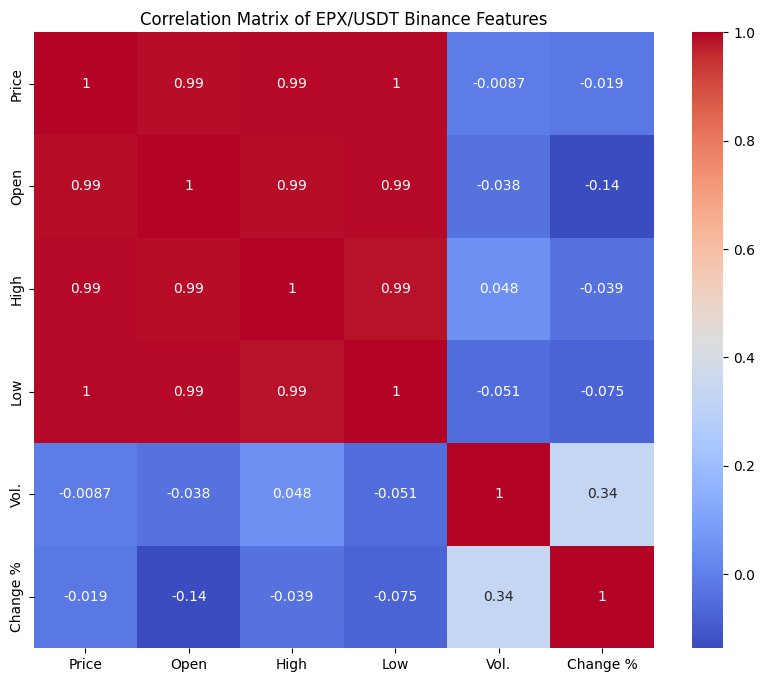

In [16]:
# Computing the correlation matrix
correlation_matrix = df.corr()

# Plotting the correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of EPX/USDT Binance Features')
plt.show()

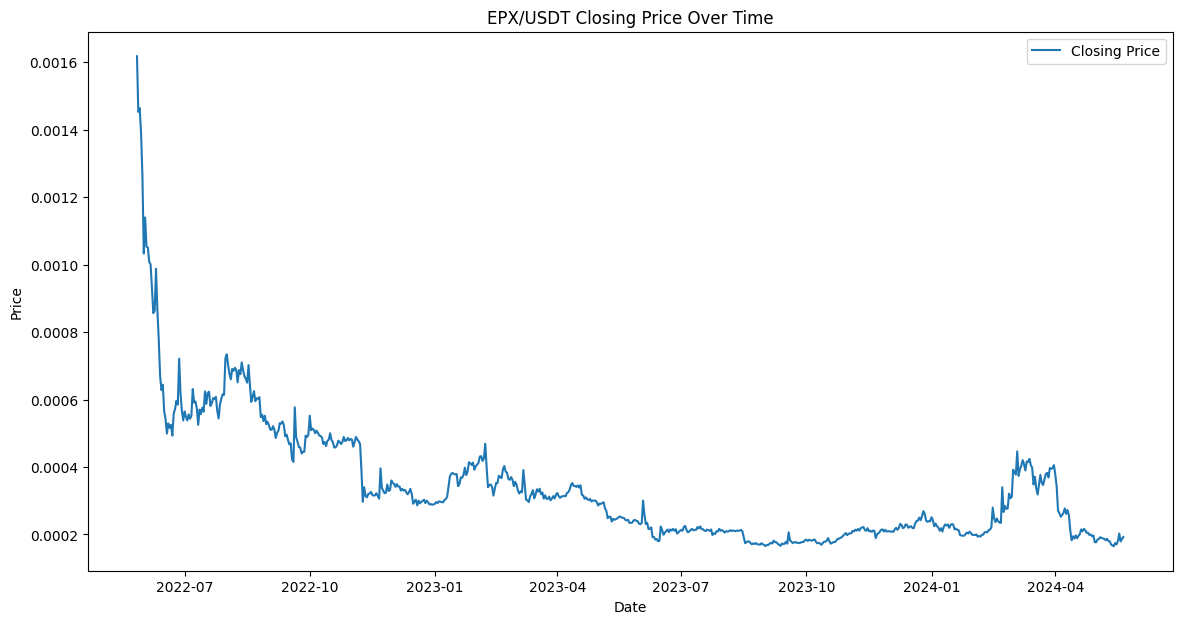

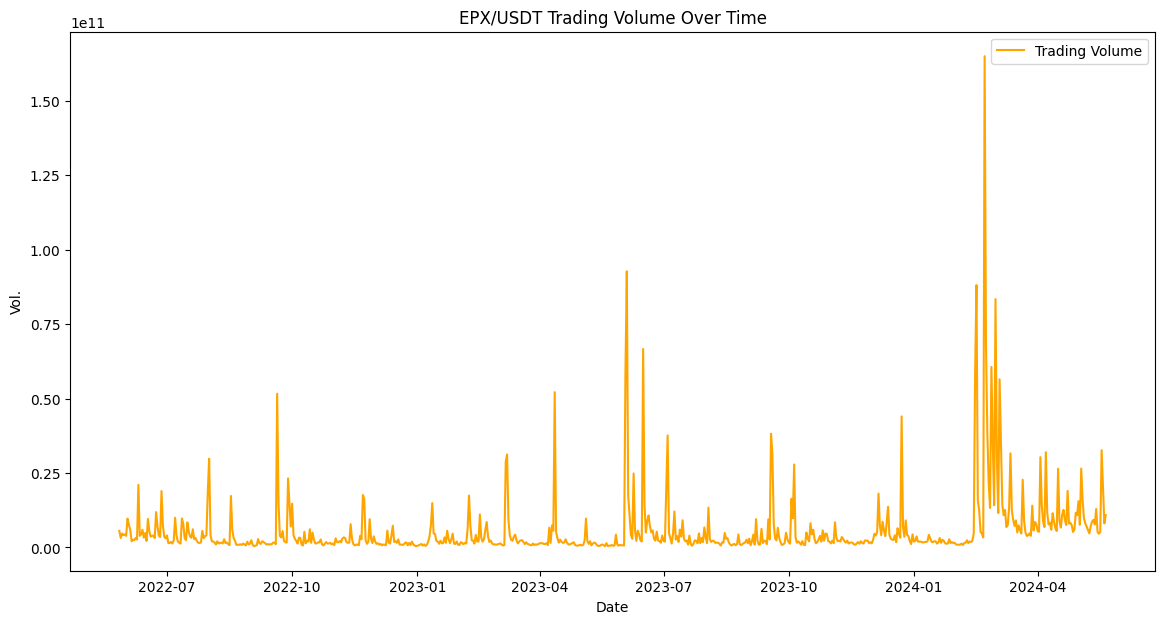

In [17]:
# Plotting Closing Price over Time
plt.figure(figsize=(14,7))
plt.plot(df.index, df['Price'], label='Closing Price')
plt.title('EPX/USDT Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plotting Trading Volume over Time
plt.figure(figsize=(14,7))
plt.plot(df.index, df['Vol.'], label='Trading Volume', color='orange')
plt.title('EPX/USDT Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Vol.')
plt.legend()
plt.show()

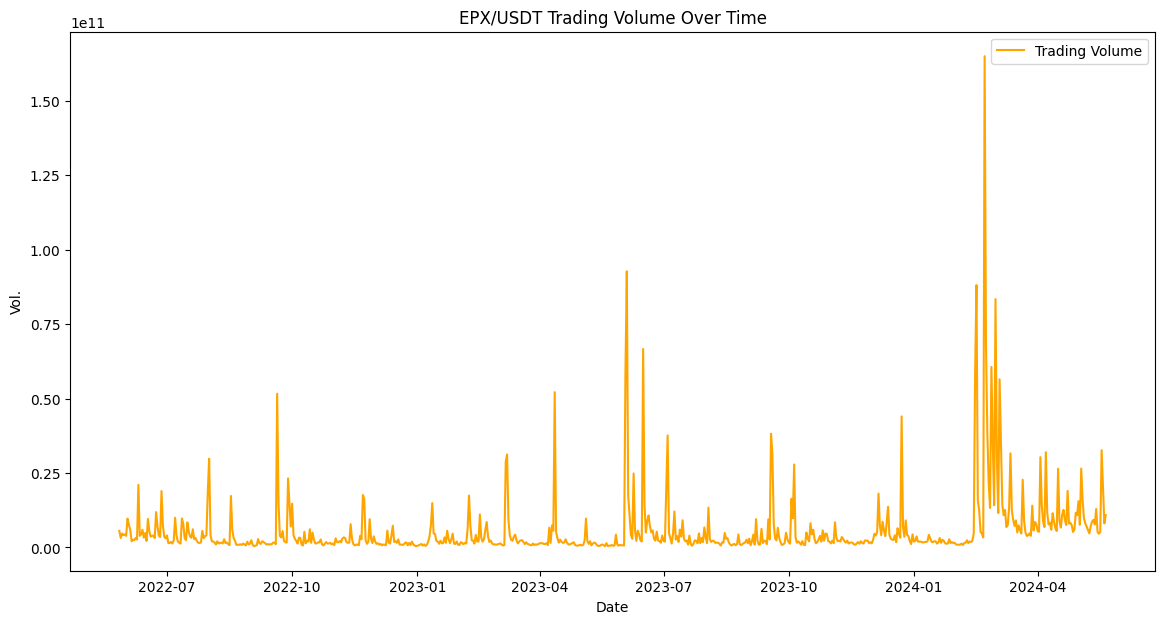

In [18]:
# Plotting Trading Volume over Time

plt.figure(figsize=(14,7))
plt.plot(df.index, df['Vol.'], label='Trading Volume', color='orange')
plt.title('EPX/USDT Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Vol.')
plt.legend()
plt.show()

In [19]:
# Importing necessary libraries for data preprocessing
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Selecting the features to be used for training
features = ['Open', 'High', 'Low', 'Vol.', 'Price']

# Normalizing the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# Inspecting the first few rows of the scaled data
scaled_data[:5]

array([[1.        , 1.        , 1.        , 0.03117927, 1.        ],
       [0.99453515, 0.9655045 , 0.86640949, 0.01684347, 0.88644184],
       [0.90573127, 0.82197856, 0.83854836, 0.02583372, 0.89401239],
       [0.88660428, 0.83922632, 0.86998143, 0.02273573, 0.84377151],
       [0.84083612, 0.75729949, 0.74139163, 0.02419361, 0.75705437]])

In [20]:
# Splitting the data into training and test sets (80% Train, 20% Test)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Checking the shapes of the training and test sets
print(f'Training data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

Training data shape: (580, 5)
Test data shape: (146, 5)


In [21]:
# Defining a function to create sequences of data
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length][4])  # Price is the label (5th column index)
    return np.array(sequences), np.array(labels)

# Defining sequence length
seq_length = 60

# Creating sequences for training and test sets
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Checking the shapes of the resulting arrays
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (520, 60, 5), y_train shape: (520,)
X_test shape: (86, 60, 5), y_test shape: (86,)


In [22]:
# Reshaping for the LSTM model and others requiring 3D data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(features))
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], len(features))

# Displaying the shape of training and testing data
print(f'Reshaped X_train shape: {X_train.shape}')
print(f'Reshaped X_test shape: {X_test.shape}')

Reshaped X_train shape: (520, 60, 5)
Reshaped X_test shape: (86, 60, 5)


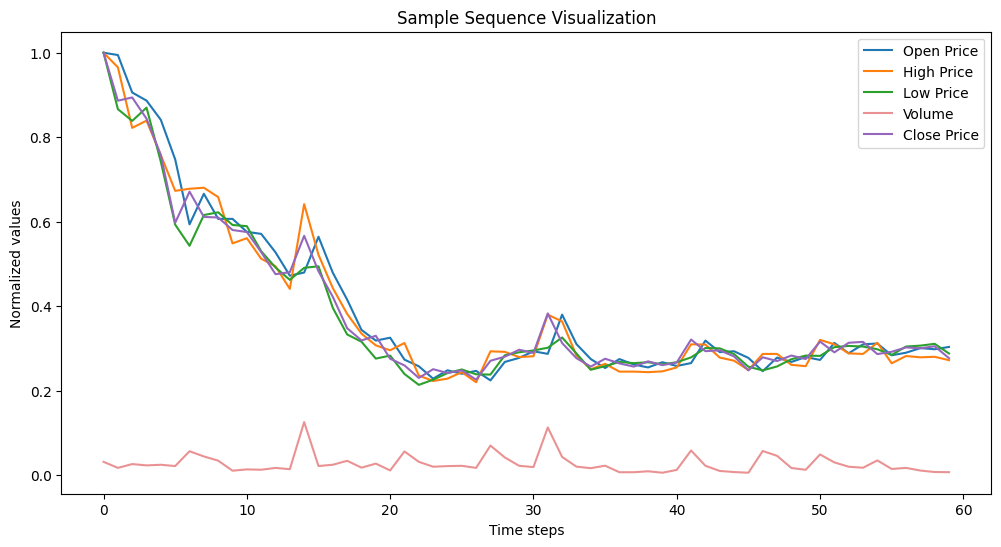

In [23]:
# Visualizing a sample sequence from the training data
import matplotlib.pyplot as plt

sample_sequence_index = 0

plt.figure(figsize=(12,6))
plt.plot(range(seq_length), X_train[sample_sequence_index, :, 0], label='Open Price')
plt.plot(range(seq_length), X_train[sample_sequence_index, :, 1], label='High Price')
plt.plot(range(seq_length), X_train[sample_sequence_index, :, 2], label='Low Price')
plt.plot(range(seq_length), X_train[sample_sequence_index, :, 3], label='Volume', alpha=0.5)
plt.plot(range(seq_length), X_train[sample_sequence_index, :, 4], label='Close Price')
plt.title('Sample Sequence Visualization')
plt.xlabel('Time steps')
plt.ylabel('Normalized values')
plt.legend()
plt.show()


In [25]:
# Importing necessary libraries from TensorFlow and Keras
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects
import tensorflow.keras.backend as K

# Define the custom activation function
def custom_activation(x):
    return K.tanh(x * 0.5)  # Scale the input to handle volatility

# Registering the custom activation function in Keras
get_custom_objects().update({'custom_activation': Activation(custom_activation)})

In [26]:
# Importing necessary libraries for model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, Conv1D, MaxPooling1D, LayerNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class BaseModel:

    def __init__(self, input_shape):

        self.model = Sequential()
        self.input_shape = input_shape

    def compile_model(self):
        self.model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        self.model.summary()

    def train_model(self, X_train, y_train, X_test, y_test, epochs=50, batch_size=64):
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
        return history

class LSTMModel(BaseModel):

    def __init__(self, input_shape):

        super().__init__(input_shape)
        self.model.add(LSTM(100, return_sequences=True, input_shape=self.input_shape, activation=custom_activation))
        self.model.add(Dropout(0.2))
        self.model.add(LSTM(100, return_sequences=False, activation=custom_activation))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(25))
        self.model.add(Dense(1))

class GRUModel(BaseModel):

    def __init__(self, input_shape):

        super().__init__(input_shape)
        self.model.add(GRU(100, return_sequences=True, input_shape=self.input_shape, activation=custom_activation))
        self.model.add(Dropout(0.2))
        self.model.add(GRU(100, return_sequences=False, activation=custom_activation))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(25))
        self.model.add(Dense(1))

class SimpleRNNModel(BaseModel):

    def __init__(self, input_shape):

        super().__init__(input_shape)
        self.model.add(SimpleRNN(100, return_sequences=True, input_shape=self.input_shape, activation=custom_activation))
        self.model.add(Dropout(0.2))
        self.model.add(SimpleRNN(100, return_sequences=False, activation=custom_activation))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(25))
        self.model.add(Dense(1))

class ConvLSTMModel(BaseModel):

    def __init__(self, input_shape):

        super().__init__(input_shape)
        self.model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=self.input_shape))
        self.model.add(MaxPooling1D(pool_size=2))
        self.model.add(LSTM(100, return_sequences=True, activation=custom_activation))
        self.model.add(Dropout(0.2))
        self.model.add(LSTM(100, return_sequences=False, activation=custom_activation))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(25))
        self.model.add(Dense(1))

class TransformerModel(BaseModel):

    def __init__(self, input_shape):

        super().__init__(input_shape)
        self.build_transformer()

    def build_transformer(self):

        input_layer = Input(shape=self.input_shape)

        x = LayerNormalization(epsilon=1e-6)(input_layer)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.2)(x)

        dense_output = Dense(64, activation=custom_activation)(x)
        output_layer = Dense(1)(dense_output)

        self.model = Model(inputs=input_layer, outputs=output_layer)

# Initialize Models
input_shape = (X_train.shape[1], X_train.shape[2])

lstm_model = LSTMModel(input_shape)
gru_model = GRUModel(input_shape)
rnn_model = SimpleRNNModel(input_shape)
conv_lstm_model = ConvLSTMModel(input_shape)
transformer_model = TransformerModel(input_shape)

In [27]:
# Compiling the Models

lstm_model.compile_model()
gru_model.compile_model()
rnn_model.compile_model()
conv_lstm_model.compile_model()
transformer_model.compile_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           42400     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 125351 (489.65 KB)
Trainable params: 12535

In [29]:
Model: "sequential"

In [31]:
# Training the Models
history_lstm = lstm_model.train_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=64)
history_gru = gru_model.train_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=64)
history_rnn = rnn_model.train_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=64)
history_conv_lstm = conv_lstm_model.train_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=64)
history_transformer = transformer_model.train_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=64)

Epoch 1/50
9/9 [==============================] - 4s 465ms/step - loss: 3.8667e-04 - val_loss: 8.5711e-04
Epoch 2/50
9/9 [==============================] - 3s 358ms/step - loss: 4.1812e-04 - val_loss: 9.0222e-04
Epoch 3/50
9/9 [==============================] - 3s 338ms/step - loss: 4.0793e-04 - val_loss: 8.3186e-04
Epoch 4/50
9/9 [==============================] - 4s 429ms/step - loss: 3.8021e-04 - val_loss: 8.5784e-04
Epoch 5/50
9/9 [==============================] - 3s 320ms/step - loss: 3.4307e-04 - val_loss: 8.2480e-04
Epoch 6/50
9/9 [==============================] - 2s 173ms/step - loss: 3.4757e-04 - val_loss: 8.2608e-04
Epoch 7/50
9/9 [==============================] - 2s 171ms/step - loss: 3.3016e-04 - val_loss: 8.2114e-04
Epoch 8/50
9/9 [==============================] - 2s 175ms/step - loss: 3.5773e-04 - val_loss: 7.9528e-04
Epoch 9/50
9/9 [==============================] - 2s 170ms/step - loss: 3.8088e-04 - val_loss: 8.0106e-04
Epoch 10/50
9/9 [=============================

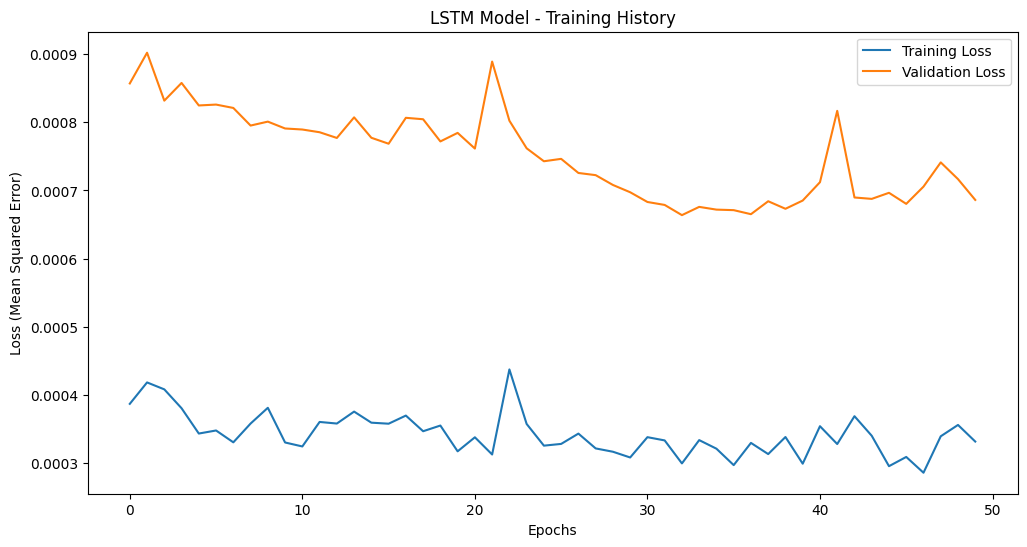

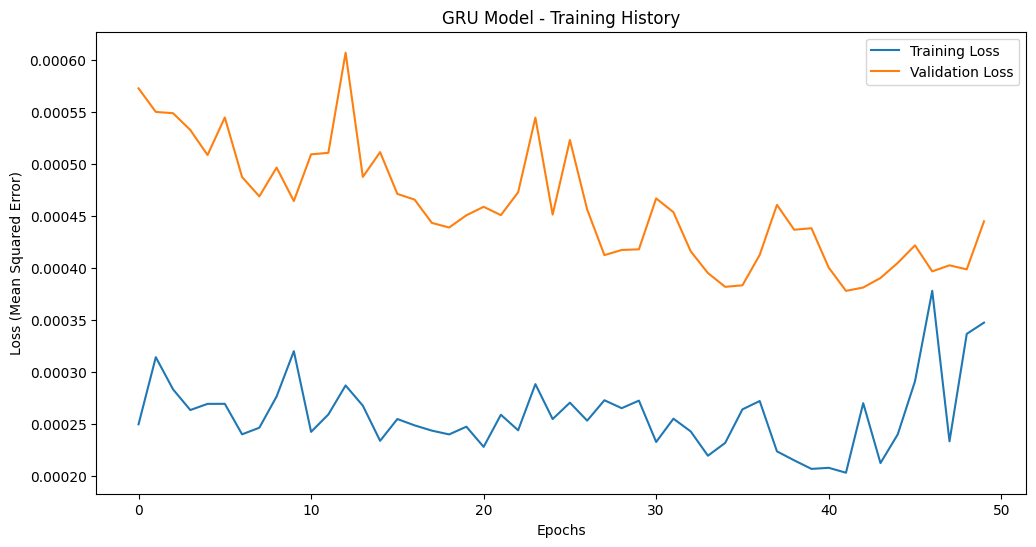

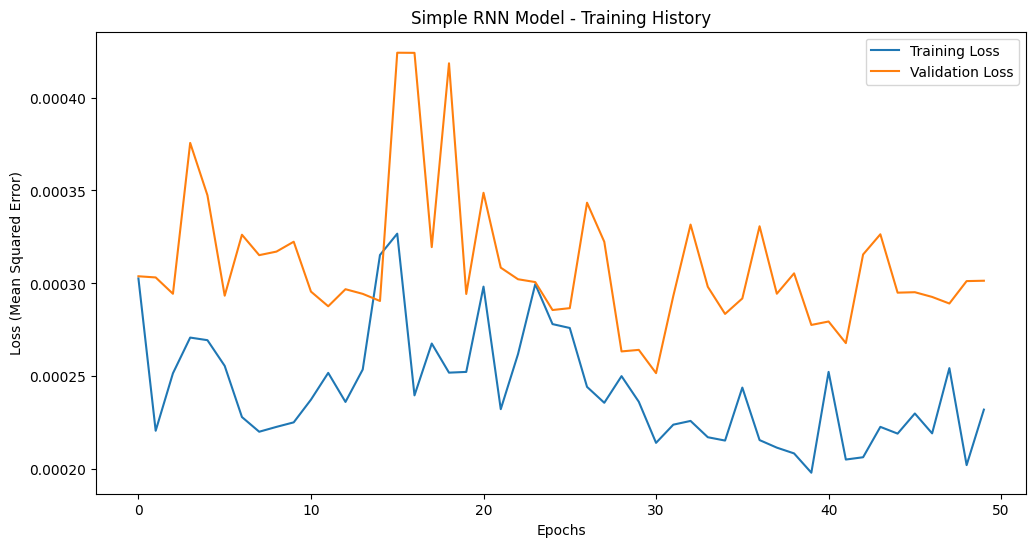

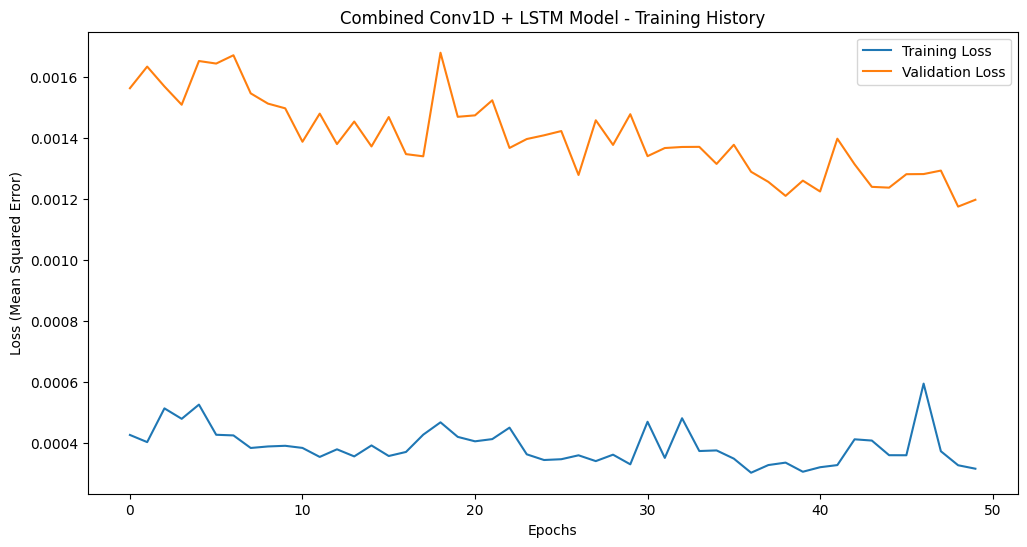

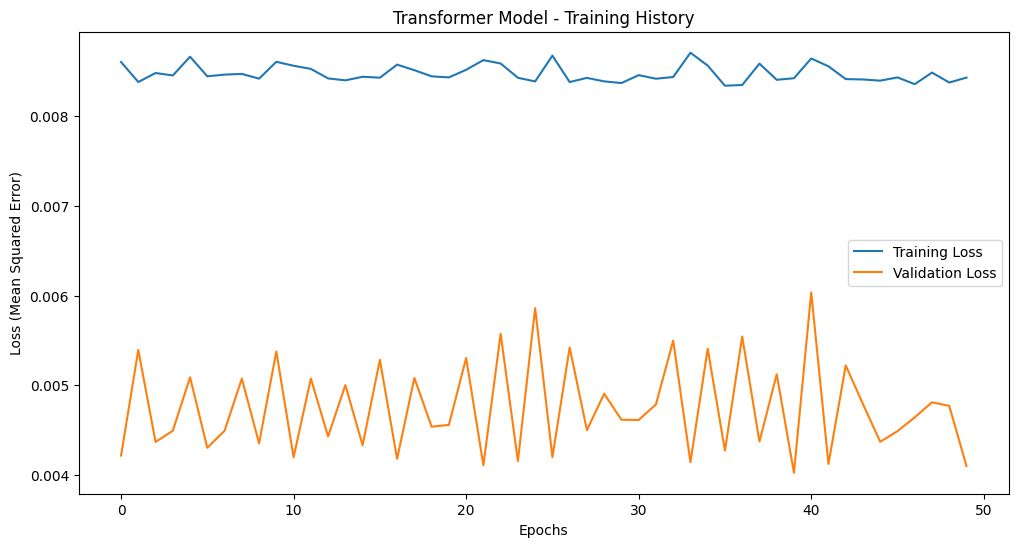

In [32]:
# Function to plot training history
def plot_training_history(history, title):
    plt.figure(figsize=(12,6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Mean Squared Error)')
    plt.legend()
    plt.show()



# Plotting training history for each model
plot_training_history(history_lstm, 'LSTM Model - Training History')
plot_training_history(history_gru, 'GRU Model - Training History')
plot_training_history(history_rnn, 'Simple RNN Model - Training History')
plot_training_history(history_conv_lstm, 'Combined Conv1D + LSTM Model - Training History')
plot_training_history(history_transformer, 'Transformer Model - Training History')

3/3 [==============================] - 2s 60ms/step


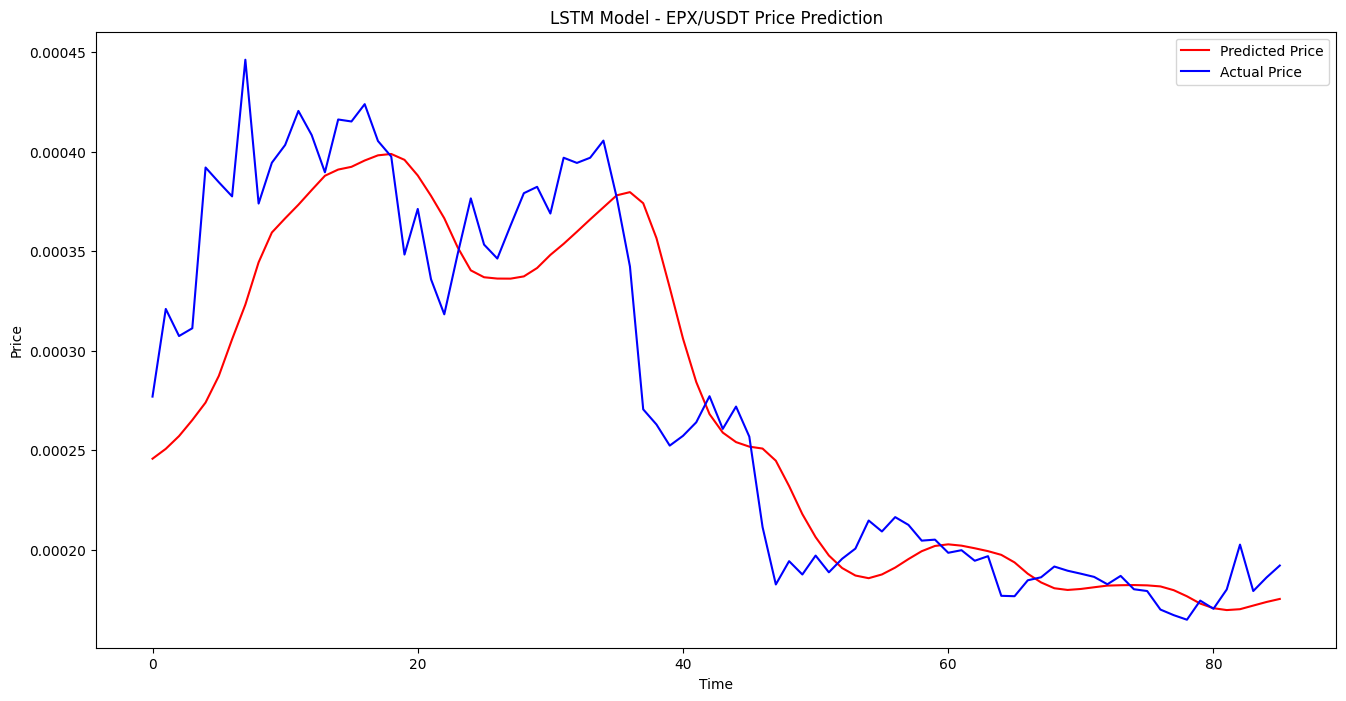

3/3 [==============================] - 0s 31ms/step


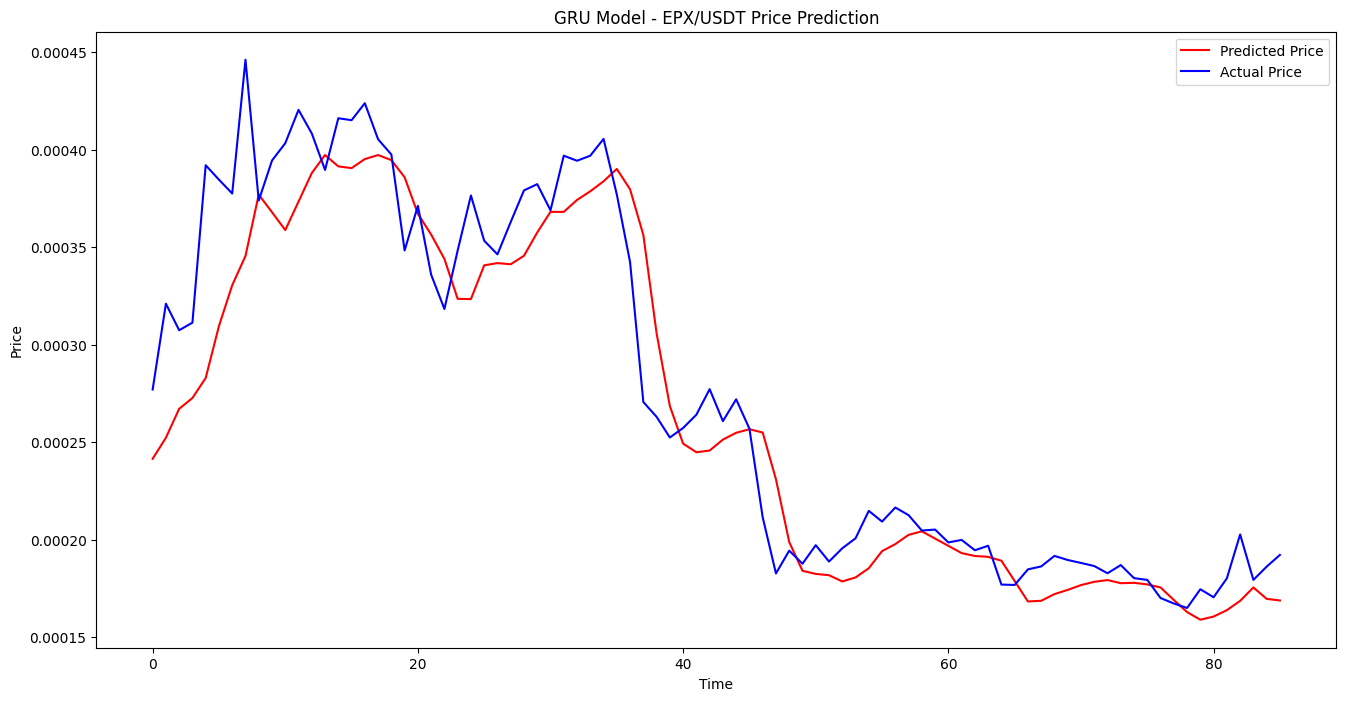

3/3 [==============================] - 0s 12ms/step


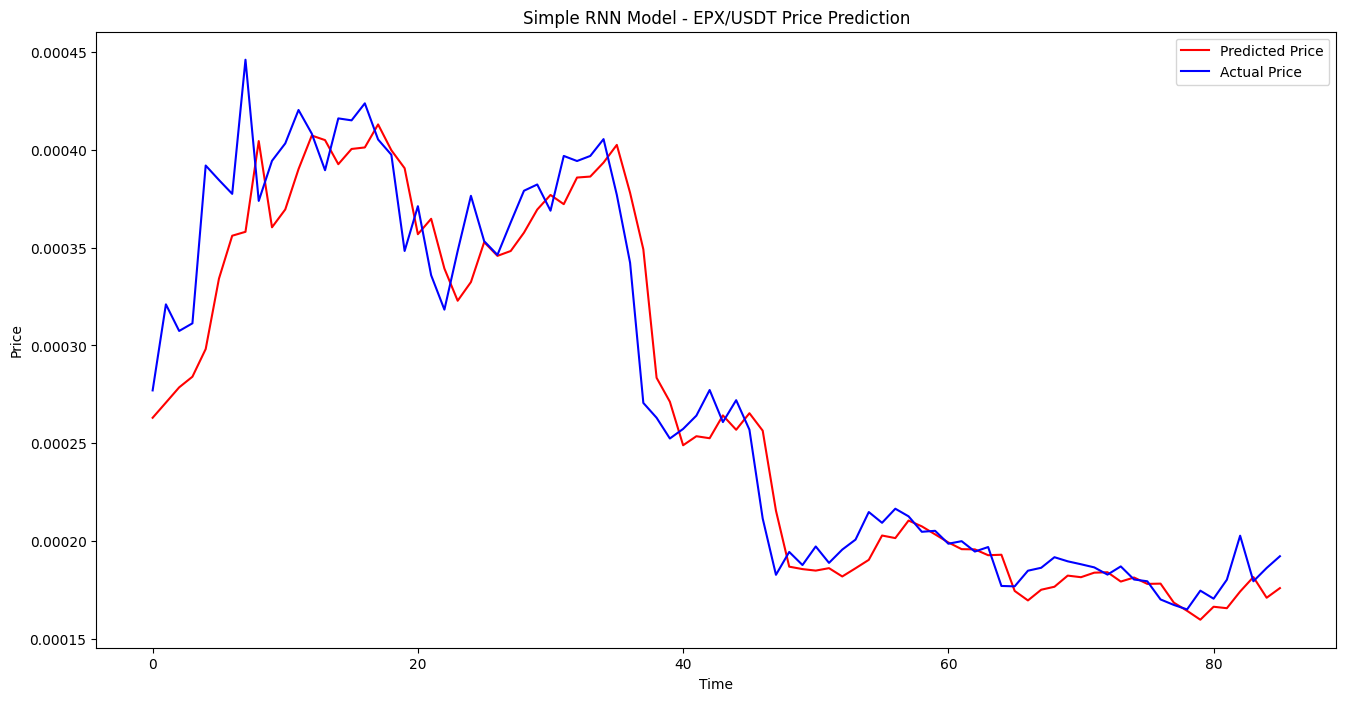

3/3 [==============================] - 0s 18ms/step


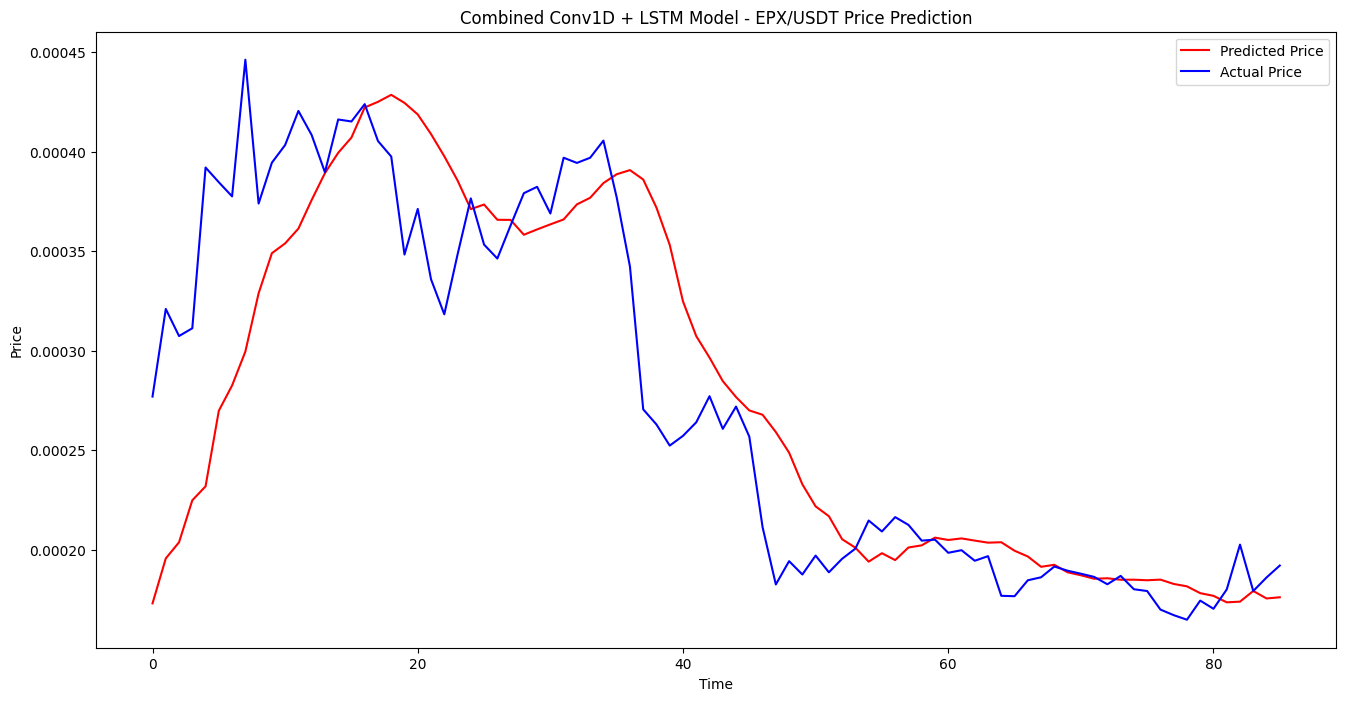

3/3 [==============================] - 0s 8ms/step


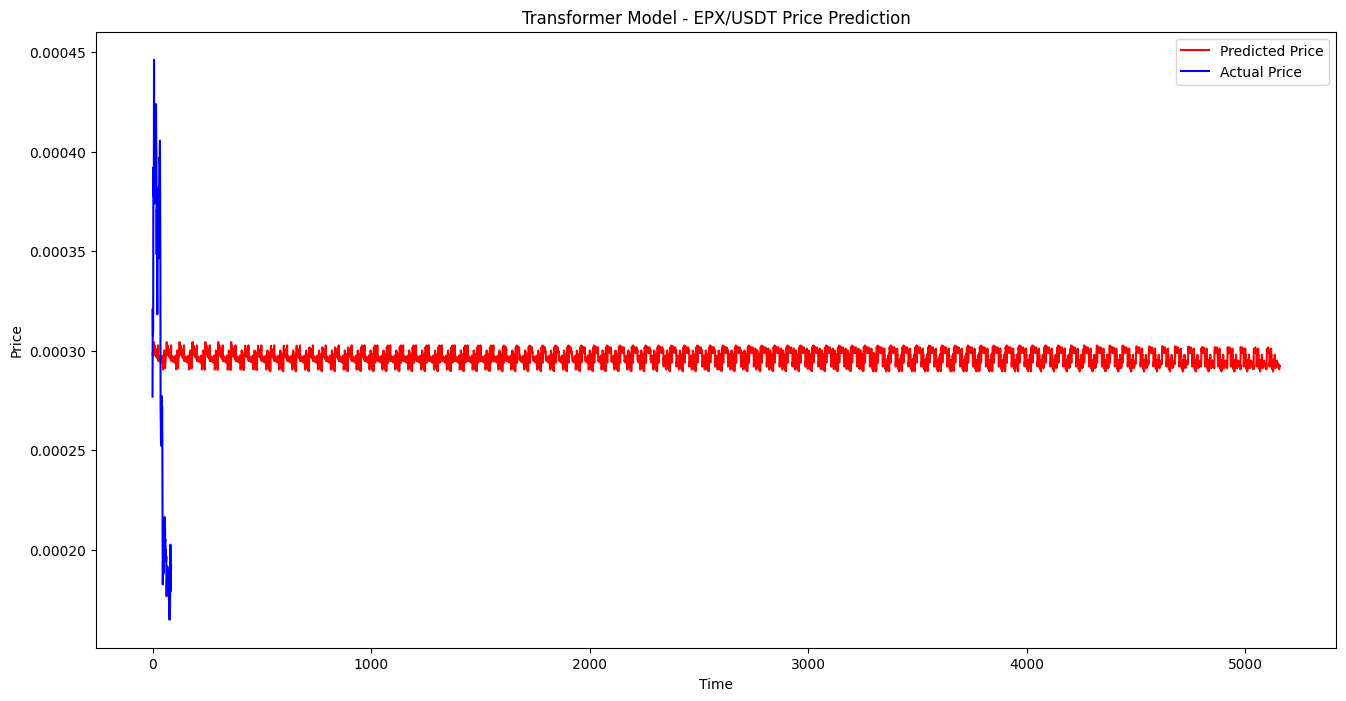

In [33]:
# Function to evaluate and plot predictions
def evaluate_model(model_class, X_test, y_test, title):

    model = model_class.model
    predictions = model.predict(X_test)

    # Ensure predictions and y_test are reshaped appropriately
    predictions = predictions.reshape(-1)
    y_test = y_test.reshape(-1)

    # Prepare the data for inverse transformation with only the last column filled
    predictions_scaled = np.zeros((len(predictions), len(features)))
    actual_scaled = np.zeros((len(y_test), len(features)))

    predictions_scaled[:, -1] = predictions
    actual_scaled[:, -1] = y_test

    # Perform inverse transform
    predictions_transformed = scaler.inverse_transform(predictions_scaled)[:, -1]
    actual_transformed = scaler.inverse_transform(actual_scaled)[:, -1]

    # Plotting the actual vs predicted prices
    plt.figure(figsize=(16,8))
    plt.plot(predictions_transformed, color='red', label='Predicted Price')
    plt.plot(actual_transformed, color='blue', label='Actual Price')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Evaluating each model
evaluate_model(lstm_model, X_test, y_test, 'LSTM Model - EPX/USDT Price Prediction')
evaluate_model(gru_model, X_test, y_test, 'GRU Model - EPX/USDT Price Prediction')
evaluate_model(rnn_model, X_test, y_test, 'Simple RNN Model - EPX/USDT Price Prediction')
evaluate_model(conv_lstm_model, X_test, y_test, 'Combined Conv1D + LSTM Model - EPX/USDT Price Prediction')
evaluate_model(transformer_model, X_test, y_test, 'Transformer Model - EPX/USDT Price Prediction')